# Homework 9

In this homework we'll dig deeper into multiple regression, how it's done, and why it's important.


In [20]:
# Don't change this cell; just run it. 
# The result will give you directions about how to log in to the submission system, called OK.
# Once you're logged in, you can run this cell again, but it won't ask you who you are because
# it remembers you. However, you will need to log in once per assignment.
from client.api.notebook import Notebook
ok = Notebook('hw9.ok')
#_ = ok.auth(inline=True)

Assignment: HW 9
OK, version v1.12.5



In [21]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel
from nistats.hemodynamic_models import glover_hrf as create_hrf
import cortex
from scipy.stats import zscore
from sklearn.linear_model import LinearRegression

Let's define our helper function to load fMRI data:

In [22]:
def load_nifti(filename, zscore=True, mask=None):
    img = nibabel.load(filename)
    data = img.get_data().T
    if mask is not None:
        data = data[:, mask]
    if zscore:
        data = (data - data.mean(0)) / (data.std(0) + 1e-7)
    return data

And let's create a response design matrix for the motor localizer:

In [23]:
hrf = create_hrf(tr=2, oversampling=1, time_length=32)

motor_categories = np.load("/home/jovyan/motorloc_experimental_conditions.npy")
unique_motor_categories = np.unique(motor_categories)
motor_response_vectors = []
for category in unique_motor_categories:
    stimulus_vector = motor_categories == category
    response_vector = np.convolve(stimulus_vector, hrf)[:len(motor_categories)]
    motor_response_vectors.append(response_vector)
motor_response_design = np.stack(motor_response_vectors, axis=1)

In [24]:
mask = cortex.db.get_mask('s01', 'catloc', 'cortical')
data = load_nifti('/data/cogneuro/fMRI/motor/s01_motorloc.nii.gz', mask=mask)

voxel_indices = [34854, 37594, 36630, 25004, 12135, 0]
voxels = data[:, voxel_indices]

**1. Simple linear regression** 

**(a)** [1pt] Use the `sklearn` object `LinearRegression` to create a model called `linreg` and use it to perform simple linear regression between the first column of `motor_response_design` (associated with `move eyes`) and the first column of `voxels` - the time series of the first voxel, also associated with `move eyes`. 

Create a figure named `fig_regression1` of size `(10, 10)`, then make a scatterplot of the response vector (store it in `move_eyes_response`) and the voxel time series (store it in `voxel0`). 

Use the `predict` method of `linreg` to compute the predicted voxel values for the motor response vector and display them in the same plot as a line plot.

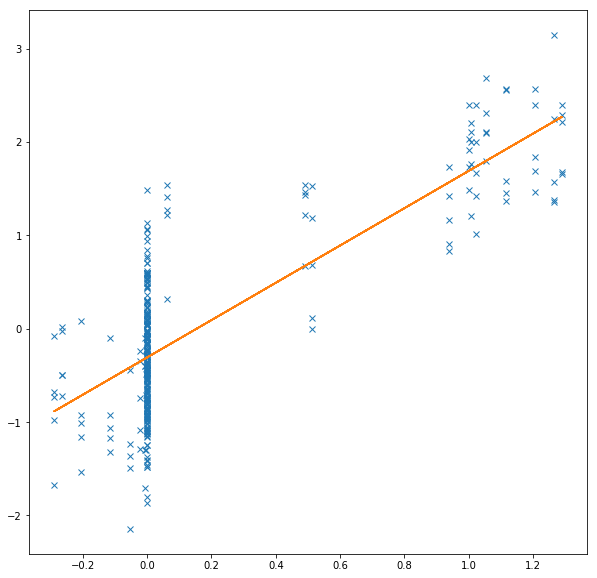

In [25]:
fig_regression1 = plt.figure(figsize=(10, 10))
linreg = LinearRegression()
response_vector = motor_response_design[:, 0]
voxel0 = voxels[:, 0]
plt.plot(response_vector, voxel0, 'x')
linreg.fit(response_vector[:, np.newaxis], voxel0)
yhat = linreg.predict(response_vector[:, np.newaxis])
plt.plot(response_vector, yhat)

**(b)** [1.5pts] Now you'll make scatter plots with the regression line (just as you did in part a) for all 36 pairs of the 6 response vectors and 6 selected voxels. You'll arrange the scatter plots such that each row of subplots will represent a voxel, and each column will represent a response vector.

Create a figure called `fig_all_scatter_plots` and make it of size `(24, 24)`.
Set a counter `counter` to 0 which you'll use to indicate which subplot to plot to. 

Write a `for` loop that iterates over `i` from 0 to the number of voxels. In the for loop:
1. extract the `i`th column of `voxels` and call it `current_voxel`. 
2. Write a second `for` loop that iterates over `j` counting from 0 to the number of response vectors. Inside this second `for` loop:
    1. Increment the counter. 
    2. Store the `j`th column from the design matrix (a response vector) in the name `current_response_vector` 
    3. Store the `j`th category in `current_category`. 
    4. Using `LinearRegression`, fit a regression model of `current_response_vector` as independent variable and `current_voxel` as dependent variable.  
    5. Select the subplot with index `counter`. 
    6. Make a scatter plot of `current_response_vector` and `current_voxel`. 
    7. Compute the y-values of the regression line and call them `current_y` using the `predict` method of the `LinearRegression` model you just fit. 
    8. Plot the regression line. 
    9. Add a title showing `'voxel {i} / {category}'`. 

You should be able to easily identify which category has a positive regression slope for which voxel by examining these plots.

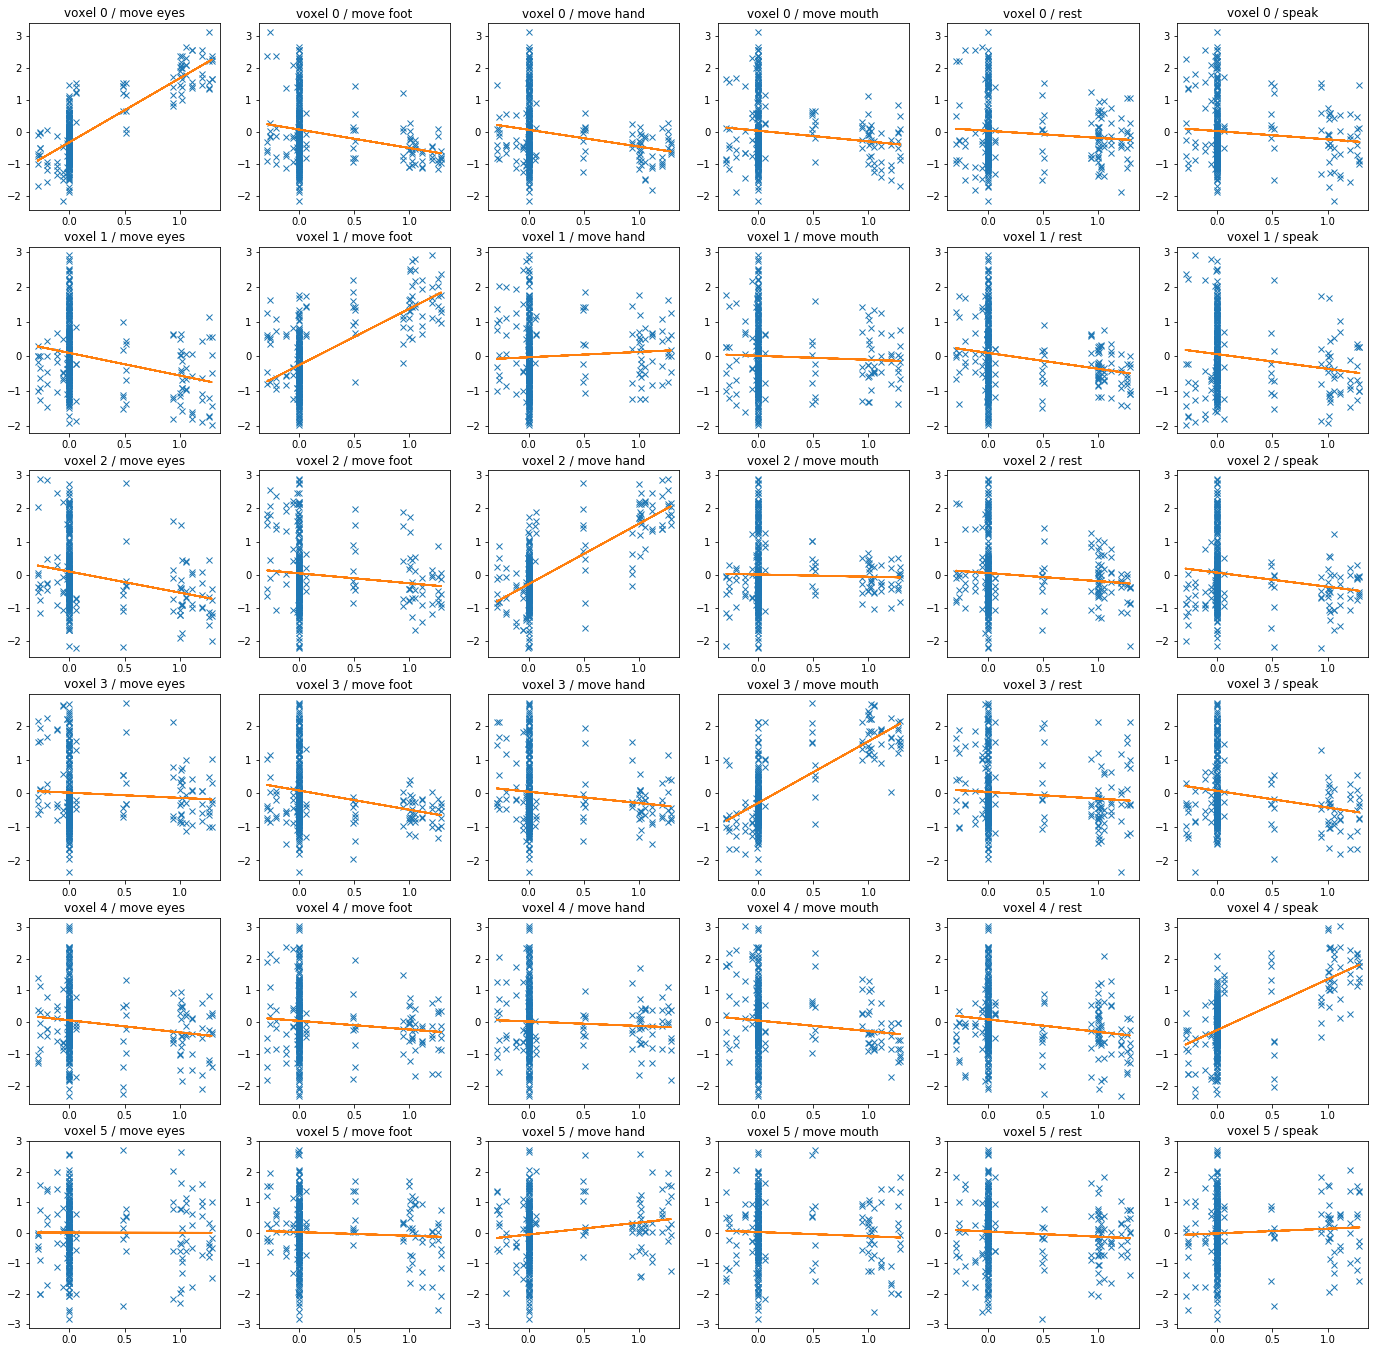

In [26]:
plt.figure(figsize=(24, 24))
counter = 0
for i in range(voxels.shape[1]):
    current_voxel = voxels[:, i]
    for j in range(len(unique_motor_categories)):
        counter += 1
        current_response_vector = motor_response_design[:, j]
        current_category = unique_motor_categories[j]
        plt.subplot(voxels.shape[1], len(unique_motor_categories), counter)
        plt.plot(current_response_vector, current_voxel, 'x')
        linreg = LinearRegression()
        linreg.fit(current_response_vector[:, np.newaxis], current_voxel)
        y_hat = linreg.predict(current_response_vector[:, np.newaxis])
        plt.plot(current_response_vector, y_hat)
        plt.title("voxel {} / {}".format(i, current_category))

**(c)** [1.5pts] Now you can also display the corresponding line plots. 

Make a figure of shape `(20, 20)` called `fig_line_plots` in which you arrange 5 subplots vertically (they will be wide to accommodate a time series). Each subplot should plot the following for one voxel:
1. The voxel's BOLD timeseries
2. All 6 response vectors multiplied by their estimated slopes and incremented by their respective intercepts. This will display each response vector's best fit to the time series. 
3. Label every plot appopriately and add a legend. 
4. Label the x and y axes appropriately (you can use either time or TRs, just make sure the numbers are correct for the label).
5. Give each subplot a title that indicates the voxel and motor task being plotted.

To do this, you will need two nested for loops just as above. The necessary slopes and intercepts are exactly the same as above, but for each voxel time series the 6 predictions get plotted into the same line plot.

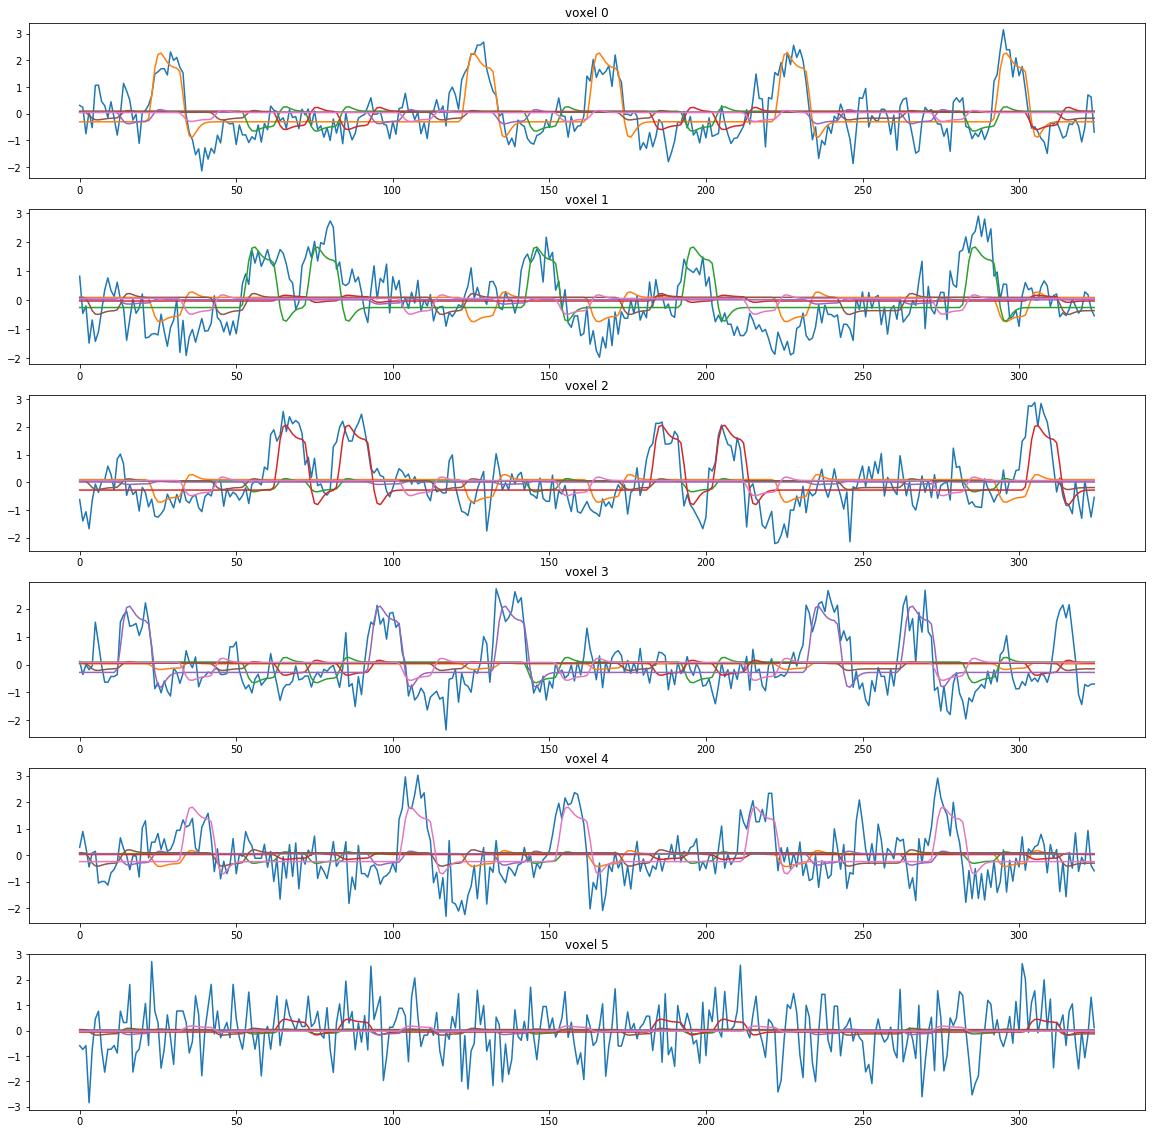

In [27]:
fig_line_plots = plt.figure(figsize=(20, 20))

counter = 0
for i in range(voxels.shape[1]):
    current_voxel = voxels[:, i]
    counter = counter + 1
    plt.subplot(voxels.shape[1], 1, counter)
    plt.plot(current_voxel, label='voxel {}'.format(i))
    for j in range(len(unique_motor_categories)):
        current_response_vector = motor_response_design[:, j]
        linreg = LinearRegression()
        linreg.fit(current_response_vector[:, np.newaxis], current_voxel)
        y = linreg.predict(current_response_vector[:, np.newaxis])
        plt.plot(y)
    plt.title("voxel {}".format(i))

**2. Multiple linear regression** You will now perform multiple linear regression on the same voxels and look at the predicted responses.

**(a)** [0.5pts] Create a `LinearRegression` object called `reg_mult`. Fit the full model (all 6 independent variables) to all 6 voxels in one step using `reg_mult.fit` with the `motor_response_design` as the independent variable and `voxels` as the dependent variable.

In [28]:
reg_mult = LinearRegression()
reg_mult.fit(motor_response_design, voxels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

**(b)** [0.5pts] Use the `reg_mult` object to compute the predictions for the full model on all 6 voxels using `motor_response_design`, and call the resulting predictions `y_hat`. 

Make a figure of size `(20, 2)` and plot the BOLD time series of the first voxel along with the predicted time series for the same voxel. Label both plots appopriately and plot a legend. Also label the x and y axes appropriately (you can use either time or TRs, just make sure the numbers are correct for the label).


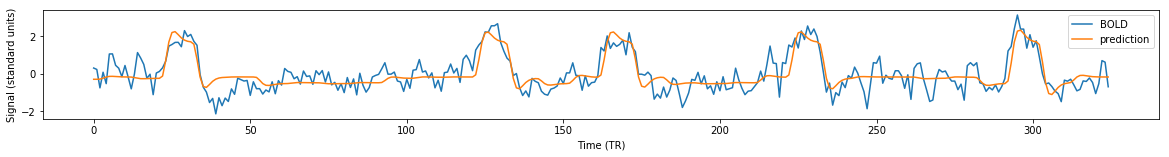

In [29]:
y_hat = reg_mult.predict(motor_response_design)
fig = plt.figure(figsize=(20, 2))
plt.plot(voxels[:, 0], label='BOLD')
plt.plot(y_hat[:, 0], label='prediction')
plt.legend()
plt.xlabel('Time (TR)')
plt.ylabel('Signal (standard units)')

**(c)** [1.5pts] Now we're going to pull apart the contributions of each motor task to the predicted time series of the full model. We'll visualize this by plotting the contributions to `y_hat` from every motor task so we can compare them with those we calculated with simple linear regression and get a feeling for how simple and multiple linear regression calculate different solutions. 

1. Use indexing to select the coefficients (weights) for all 6 motor tasks for the first voxel from the model `reg_mult.coef_`. Store them in a name called `weights_full_voxel0`. Also store the intercept for the first voxel in a name called `intercept_full_voxel0`
2. Create an empty list called `multiplied_response_vectors`
3. In a `for` loop that iterates over `i` from 0 to the number of motor tasks, calculate the contribution of each motor task to the predicted time series by multiplying the `i`th column with the `i`th weight from `weights_full_voxel0`. Append this product to `multiplied_response_vectors`. 
4. Sum `multiplied_response_vectors` along `axis=0` and add `intercept_full_voxel0` to this, storing the result in `y_hat_2`. 
5. Use `np.allclose` to see that `y_hat_2` and `y_hat` are equal. If they are not, make sure you selected the correct weights in the first step. 
6. Create a figure of `figsize=(20, 2)`. 
7. In a for loop that iterates over `i` from 0 to the number of motor tasks, plot each of the `multiplied_response_vectors` and give each one an appropriate label.
8. Add a legend.
9. Give the x and y axes appropriate labels.


True


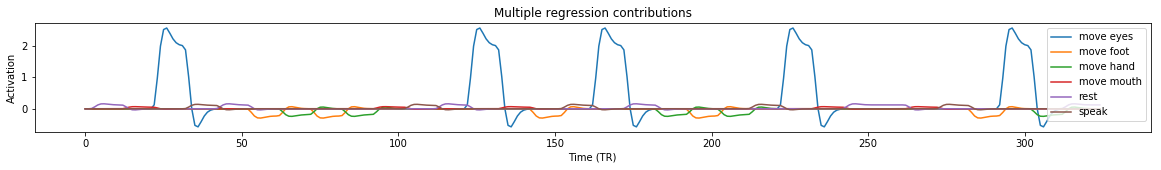

In [30]:
weights_full_voxel0 = reg_mult.coef_[0]
intercept_full_voxel0 = reg_mult.intercept_[0]
multiplied_response_vectors = []
for i in range(motor_response_design.shape[1]):
    multiplied_response_vectors.append(weights_full_voxel0[i] * motor_response_design[:, i])
y_hat_2 = np.sum(multiplied_response_vectors, axis=0) + intercept_full_voxel0
print(np.allclose(y_hat[:, 0], y_hat_2))
plt.figure(figsize=(20, 2))
for i in range(len(multiplied_response_vectors)):
    response = multiplied_response_vectors[i]
    plt.plot(response, label=unique_motor_categories[i])
plt.legend()
plt.xlabel("Time (TR)")
plt.ylabel("Activation")
plt.title("Multiple regression contributions")


**(d)** [0.5pts] Now make a similar plot to that from part **c**, but use the slopes and intercepts that you calculated using simple linear regression in question **1**. If you stored the models in question **1**, you can use them directly. Otherwise you can reuse your code from above, copy it to here and make it fit your needs.



For each column in `motor_response_design`, fit a `LinearRegression` to the first voxel, then predict its activity. Plot all of these predictions into one plot like above

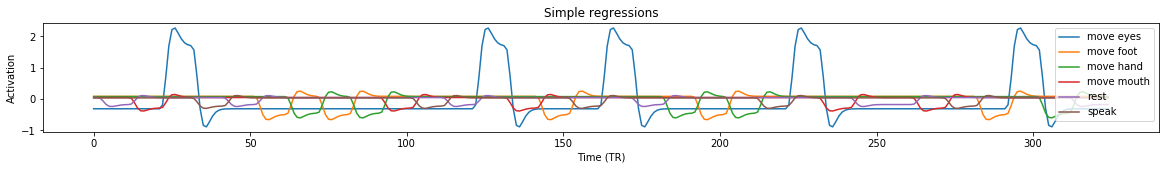

In [12]:
plt.figure(figsize=(20, 2))
for i in range(motor_response_design.shape[1]):
    p = LinearRegression().fit(motor_response_design[:, i:i + 1], voxels[:, 0]).predict(motor_response_design[:, i:i+1])
    plt.plot(p, label=unique_motor_categories[i])
plt.legend()
plt.xlabel("Time (TR)")
plt.ylabel("Activation")
plt.title("Simple regressions")

**(e)** [0.5pts]We observe that the predicted quantities differ noticeably, so let's make a direct comparison in the same plot to get a better feel for this difference. We'll plot the multiple linear regression predictions in red, and the simple linear regression predictions in blue:

Create a figure of size `(20, 2)`, in which you plot the above two plots together. Use `plt.plot(x, y, 'r')` to plot in red and `plt.plot(x, y, 'b)` to plot in blue. Add appropriate axis labels, and, *if you want a small challenge*, a legend (but make sure it only has two entries, one for red, one for blue and not 6 for either).



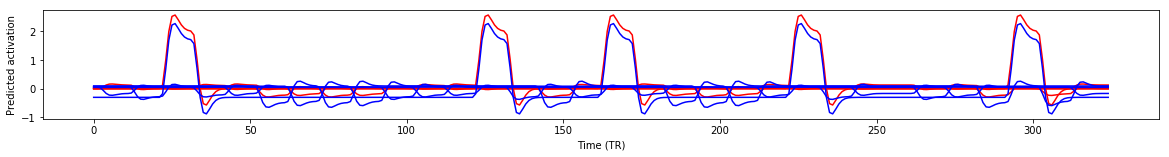

In [13]:
plt.figure(figsize=(20, 2))
for response in multiplied_response_vectors:
    plt.plot(response, 'r')
for i in range(motor_response_design.shape[1]):
    p = LinearRegression().fit(motor_response_design[:, i:i + 1], voxels[:, 0]).predict(motor_response_design[:, i:i+1])
    plt.plot(p, 'b')

plt.xlabel("Time (TR)")
plt.ylabel("Predicted activation")

We observe that the red lines (multiple regression) are more contained around 0 when the voxel is not active and show stronger activation when the voxel is active.

**3. Motor contrast maps**

In class you saw a series of localizer contrast maps for specialized visual processing regions. Now you will create similar contrast maps for the motor localizer which will identify regions of motor cortex that control different parts of the body. The motor contrast maps you will create are 

- move hand - rest
- move foot - rest
- move eyes - rest
- speak - rest
- speak - move mouth

Let's start by setting up the first one

**(a)** [0.5pts] Print `unique_motor_categories` in order to know which column of `motor_response_design` corresponds to which task. Create a `LinearRegression` model called `full_reg` and use it to fit all 6 motor tasks (`motor_response_design`) to all the cortical voxels (`data`). This model will give you a weight for each of the 6 motor tasks across all the cortical voxels. Extract all the weights for each of the 6 motor tasks from  `full_reg.coef_` and store them in corresponding names `weight_move_eyes`, `weight_move_foot`, ..., `weight_speak`.



In [14]:
print(unique_motor_categories)
full_reg = LinearRegression().fit(motor_response_design, data)

['move eyes' 'move foot' 'move hand' 'move mouth' 'rest' 'speak']


In [15]:
weight_move_eyes, weight_move_foot, weight_move_hand, weight_move_mouth, weight_rest, weight_speak = full_reg.coef_.T

**(b)** [1pt] Create the first contrast which localizes the region of motor cortex that controls the hand by by subtracting `weight_rest` from `weight_move_hand` and call it `c_hand_vs_rest`. Create a cortex volume called `vol_c_hand_vs_rest` and display it as a flatmap. Give it the title "Hand vs Rest".

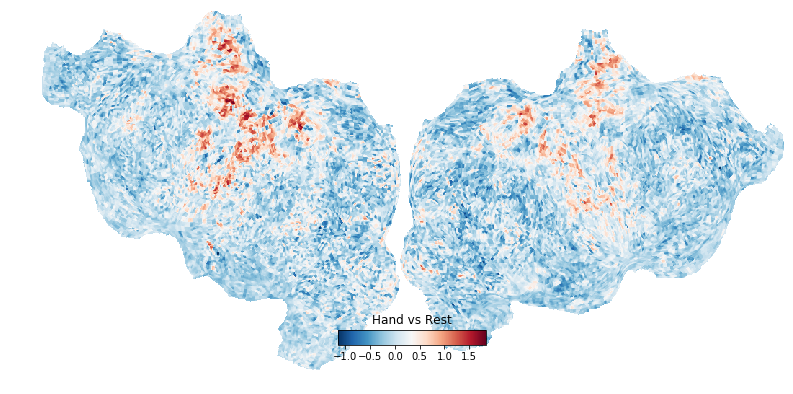

In [16]:
c_hand_vs_rest = weight_move_hand - weight_rest
vol_c_hand_vs_rest = cortex.Volume(c_hand_vs_rest, 's01', 'catloc')
cortex.quickflat.make_figure(vol_c_hand_vs_rest)
plt.title("Hand vs Rest")
pass

**(c)** [1pt] Now create the remaining 5 contrasts and make a flatmap for each, just as in part **(b)**, calling the contrasts: `c_foot_vs_rest`, `c_eyes_vs_rest`, `c_speak_vs_rest`, and `c_speak_vs_mouth`.

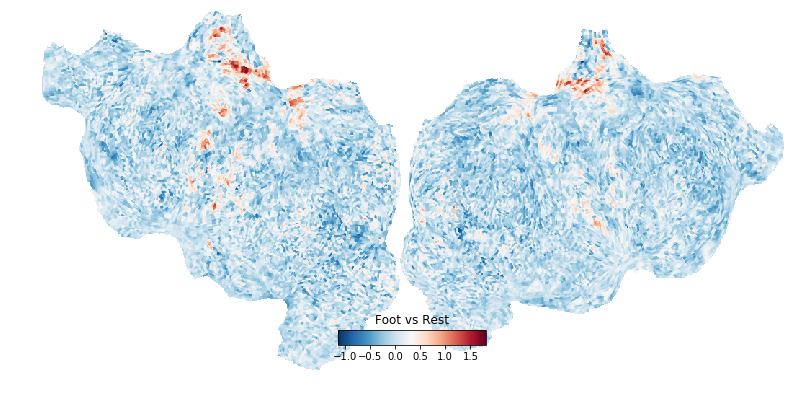

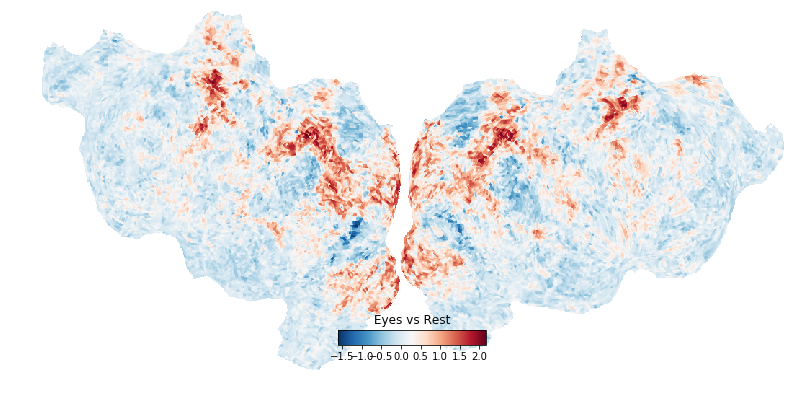

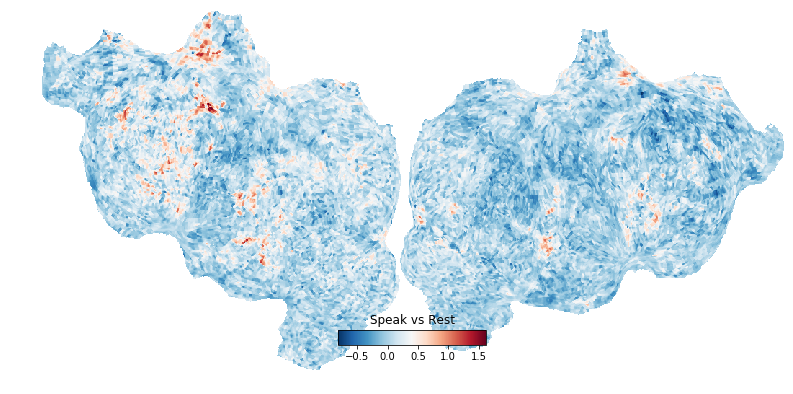

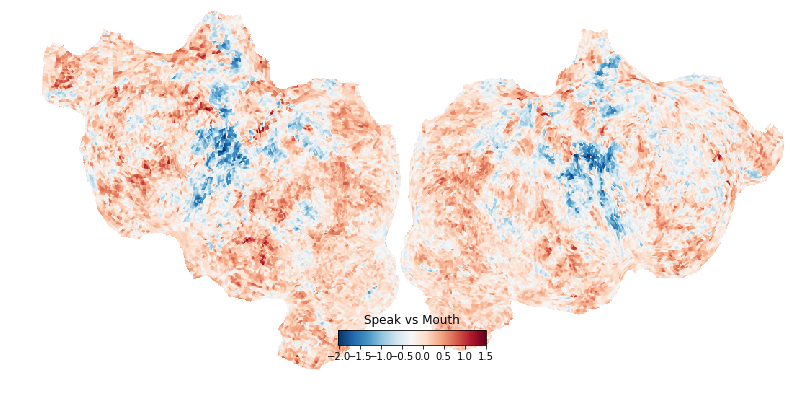

In [17]:
c_foot_vs_rest = weight_move_foot - weight_rest
vol_c_foot_vs_rest = cortex.Volume(c_foot_vs_rest, 's01', 'catloc')
cortex.quickflat.make_figure(vol_c_foot_vs_rest)
plt.title("Foot vs Rest")

c_eyes_vs_rest = weight_move_eyes - weight_rest
vol_c_eyes_vs_rest = cortex.Volume(c_eyes_vs_rest, 's01', 'catloc')
cortex.quickflat.make_figure(vol_c_eyes_vs_rest)
plt.title("Eyes vs Rest")

c_speak_vs_rest = weight_speak - weight_rest
vol_c_speak_vs_rest = cortex.Volume(c_speak_vs_rest, 's01', 'catloc')
cortex.quickflat.make_figure(vol_c_speak_vs_rest)
plt.title("Speak vs Rest")

c_speak_vs_mouth = weight_speak - weight_move_mouth
vol_c_speak_vs_mouth = cortex.Volume(c_speak_vs_mouth, 's01', 'catloc')
cortex.quickflat.make_figure(vol_c_speak_vs_mouth)
plt.title("Speak vs Mouth")



**(d)** [0.5pts] *Extra credit* For the visual category localizer in class we had to contrast two different conditions - contrasting against `nothing/rest` didn't yield the desired result. Why do you think it is OK to use `rest` as a contrast here?

Make sure to submit your homework to OKpy!

In [18]:
_ = ok.submit()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving notebook... Could not save your notebook. Make sure your notebook is saved before sending it to OK!
Submit... 100% complete
Submission successful for user: michael.eickenberg@berkeley.edu
URL: https://okpy.org/cal/psych88/sp18/hw9/submissions/Y6AV20

